In [ ]:
#| default_exp utils

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# Utils

> Utilities used in the rest of the notebooks

In [ ]:
#| export
## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable
from dvats.imports import *
from fastcore.all import *
import wandb
import pickle
import pandas as pd
import numpy as np
#import tensorflow as tf
import torch.nn as nn
from fastai.basics import *
import time
import sys
import datetime
from copy import deepcopy
import traceback
from IPython.display import display, HTML
from dvats.imports import beep
from dataclasses import dataclass

## Printing

In [ ]:
#| export


In [ ]:
#| export
def print_flush(
    mssg            : str,
    print_to_path   : bool  = False,
    print_path      : str   = "~/data/logs/logs.txt",
    print_mode      : str   = 'a',
    verbose         : int   = None,
    print_time      : bool  = False,
    print_both      : bool  = False,
    **kwargs        # print args
):
    mssg_ = ""
    if verbose is not None:
        mssg_ += f"[{verbose}] "
    if print_time: 
        now = datetime.datetime.now()
        mssg_ += now.strftime('%Y-%m-%d %H:%M:%S') + f".{now.microsecond // 1000:03d}"
        mssg_ += " | "
    mssg_ += mssg
    if print_to_path:
        print_path = os.path.expanduser(print_path)
        with open(print_path, print_mode) as f:
            print(mssg_, file=f, **kwargs)
    if (not print_to_path) or (print_to_path and print_both):
        if print_both: mssg_ += " | " + print_path
        print(mssg_, **kwargs)
    sys.stdout.flush()

### Styled printing

In [ ]:
#| export

In [ ]:
#| export
def styled_print(text, color='black', size='16px', weight='normal'):
    html_text = f"<span style='color: {color}; font-size: {size}; font-weight: {weight};'>{text}</span>"
    display(HTML(html_text))

### Mssg

In [ ]:
#| export
def funcname(level = 0):
    """Get the calling function name at the specified level.
    
    Parameters:
    - level (int): How many levels to go up in the call stack.
                  0 -> Current function
                  1 -> Direct caller
                  2 -> Caller of the caller
                  and so on.

    Returns:
    - str: Name of the function at the specified call level.
           Returns "Unknown" if level exceeds the call stack depth.
    """
    return inspect.stack()[level+1][3]

In [ ]:
#| export
@dataclass
class Mssg:
    mssg    : str   =  ""
    to_path : bool  =  False
    path    : str   = "~/data/logs/logs.txt"
    mode    : str   = 'a'
    verbose : int   = 0
    color   : str   = 'black'
    size    : str   = '16px'
    weight  : str   = 'normal'
    time    : bool  = False
    both    : bool  = False
    level   : int   = 0
    function: str   = ''
    
    def __str__(self):
        return self.mssg
        
    def styled(
        self, 
        mssg    = None, 
        color   = None, 
        size    = None, 
        weight  = None
    ):
        """Formated print"""
        self.mssg   = self.mssg if mssg is None else mssg
        mssg = f" [ {self.function} ] {self.mssg}" if self.function is not None else self.mssg
        self.color  = self.color if color is None else color
        self.size   = self.size if size is  None else size
        self.weight = self.weight if weight is  None else weight
        return styled_print(self.mssg, self.color, self.size, self.weight)

    def ensure_function(self):
        if self.function is None or self.function == '':
            self.function = funcname(2)
        return self.function
        
    def print(
        self, 
        mssg            = None, 
        print_to_path   = None, 
        print_path      = None, 
        verbose         = None, 
        print_time      = None, 
        print_both      = None, 
        verbose_level   = None,
        func_name       = None,
        print_mode      = None,
        **kwargs
    ):
        """Print message with console flush and debugging parameters"""
        self.mssg       = mssg if mssg is not None else self.mssg
        self.to_path    = self.to_path if ( print_to_path is None or not isinstance(print_to_path, bool) ) else print_to_path
        self.path       = self.path if print_path is None else print_path
        self.verbose    = self.verbose if verbose is None else verbose
        self.time       = self.time if print_time is None else print_time
        self.both       = self.both if print_both is None else print_both
        self.function      = func_name if func_name is not None else self.function
        self.ensure_function()
        self.mode       = self.mode if print_mode is None else print_mode
        verbose_level   = self.level if verbose_level is None else verbose_level
        if self.verbose > verbose_level:
            mssg = f" [ {self.function} ] {self.mssg}" if self.function is not None else self.mssg
            print_flush(
                mssg, 
                print_to_path = self.to_path, 
                print_path    = self.path, 
                print_mode    = self.mode,
                verbose       = self.verbose, 
                print_time    = self.time, 
                print_both    = print_both, 
                **kwargs
            )
        self.mode = 'a'

    def print_less(self, level = None, func_name = None):
        mssg_       = deepcopy(self)
        self.ensure_function()
        mssg_.function = func_name if ( ( func_name is not None ) and func_name != '' ) else self.function
        if level is None:
            mssg_.level = mssg_.level + 1
        else:
            mssg_.level = level
        return mssg_
    def get(self, func_name = None):
        mssg_ = deepcopy(self)
        mssg_.function = funcname(2) if func_name is None else func_name
        return mssg_

    def print_less_(self, level = None, function = None):
        self.mssg = self.mssg_print_less(self, level, function)
        return self.mssg
    
    def get_less(self):
        mssg_ = self.get(funcname(2))
        mssg_.level -= 1
        return mssg_
    
    def initial_(
        self, 
        func_name       = None,
        print_to_path   = None, 
        print_path      = None, 
        verbose         = None, 
        print_time      = None, 
        print_both      = None, 
        verbose_level   = None,
        print_mode      = None,
        **kwargs
    ):
        """Print message with console flush and debugging parameters"""
        self.to_path    = self.to_path if print_to_path is None else print_to_path
        self.path       = self.path if print_path is None else print_path
        self.verbose    = self.verbose if verbose is None else verbose
        self.time       = self.time if print_time is None else print_time
        self.both       = self.both if print_both is None else print_both
        self.function   = self.function if func_name is None else func_name
        self.mode       = self.mode if print_mode is None else print_mode
        self.ensure_function()
        verbose_level   = self.level if verbose_level is None else verbose_level
        
        if self.verbose > verbose_level:
            mssg =f"[ --> {self.function} ]"
            
            print_flush(mssg, self.to_path, self.path, self.mode,self.verbose, self.time, print_both = self.both, **kwargs)
        self.mode = 'a'

    def initial(
        self, 
        func_name       = None,
        print_to_path   = None, 
        print_path      = None, 
        verbose         = None, 
        print_time      = None, 
        print_both      = None, 
        verbose_level   = None,
        print_mode      = None,
        **kwargs
    ):
        """Print message with console flush and debugging parameters"""
        to_path    = self.to_path if print_to_path is None else print_to_path
        path       = self.path if print_path is None else print_path
        verbose    = self.verbose if verbose is None else verbose
        time       = self.time if print_time is None else print_time
        both       = self.both if print_both is None else print_both
        function   = self.function if func_name is None else func_name
        mode       = self.mode if print_mode is None else print_mode
        self.ensure_function()
        verbose_level   = self.level if verbose_level is None else verbose_level
        
        if self.verbose > verbose_level:
            mssg =f"[ --> {function} ]"
            print_flush(mssg, to_path, path, mode, verbose, time, print_both, **kwargs)
        self.mode = 'a'

    def final(
        self, 
        func_name       = None,
        print_to_path   = None, 
        print_path      = None, 
        verbose         = None, 
        print_time      = None, 
        print_both      = None, 
        verbose_level   = None,
        **kwargs
    ):
        """Print message with console flush and debugging parameters"""
        self.to_path    = self.to_path if print_to_path is None else print_to_path
        self.path       = self.path if print_path is None else print_path
        self.verbose    = self.verbose if verbose is None else verbose
        self.time       = self.time if print_time is None else print_time
        self.both       = self.both if print_both is None else print_both
        self.function    = func_name if func_name is not None else self.function
        self.ensure_function()
        verbose_level   = self.level if verbose_level is None else verbose_level
        if self.verbose > verbose_level:
            mssg = f"[{self.function} --> ]"
            print_flush(mssg, self.to_path, self.path, self.mode,self.verbose, self.time, print_both, **kwargs)
        self.mode = 'a'

        

In [ ]:
#| hide
foo = Mssg(mssg = "Hi")
foo.initial(func_name = "foo")
foo.styled(color = "purple", weight = "bold")
foo.print("patata", func_name = "foo")
foo.final()

[0] [ --> foo ]


[0]  [ foo ] patata
[0] [foo --> ]


## Generate random time series dataframe

In [ ]:
#| export
def generate_TS_df(rows, cols):
    "Generates a dataframe containing a multivariate time series, where each column \
    represents a variable and each row a time point (sample). The timestamp is in the \
    index of the dataframe, and it is created with a even space of 1 second between samples"
    index = np.arange(pd.Timestamp.now(),
                      pd.Timestamp.now() + pd.Timedelta(rows-1, 'seconds'),
                      pd.Timedelta(1, 'seconds'))
    data = np.random.randn(len(index), cols)
    return pd.DataFrame(data, index=index)

In [ ]:
#| hide
df = generate_TS_df(3, 5)

In [ ]:
#| hide
test_eq(df.shape, (3, 5))

##  pandas Dataframe utilities

### Normalize columns

In [ ]:
#| export
def normalize_columns(df:pd.DataFrame):
    "Normalize columns from `df` to have 0 mean and 1 standard deviation"
    mean = df.mean()
    std = df.std() + 1e-7
    return (df-mean)/std

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
foo.describe()

,0,1,2
count,3.000000,3.000000,3.000000
mean,0.086544,-0.728360,-0.589399
std,1.134511,1.814686,0.628757
min,-1.056475,-2.048780,-1.065395
25%,-0.476360,-1.762995,-0.945783
50%,0.103755,-1.477211,-0.826171
75%,0.658053,-0.068150,-0.351401
max,1.212351,1.340911,0.123369


In [ ]:
#| hide
bar = normalize_columns(foo)
bar.describe()

,0,1,2
count,3.000000,3.000000e+00,3.000000
mean,0.000000,-3.700743e-17,0.000000
std,1.000000,9.999999e-01,1.000000
min,-1.007499,-7.276301e-01,-0.757042
25%,-0.496164,-5.701458e-01,-0.566807
50%,0.015170,-4.126615e-01,-0.376571
75%,0.503749,3.638150e-01,0.378521
max,0.992328,1.140292e+00,1.133614


In [ ]:
#| hide
test_close(bar.describe().loc['mean'].values, np.repeat(0.0, len(bar.columns)))

In [ ]:
#| hide
test_close(bar.describe().loc['std'].values, np.repeat(1.0, len(bar.columns)))

### Remove constant columns

In [ ]:
#| export
def remove_constant_columns(df:pd.DataFrame):
    return df.loc[:, (df != df.iloc[0]).any()]

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
foo['constant'] = [0.0]*len(foo)
foo

,0,1,2,constant
2025-01-07 15:10:57.265353,1.132857,0.955266,-1.881711,0.0
2025-01-07 15:10:58.265353,-0.221849,-0.226002,0.699696,0.0
2025-01-07 15:10:59.265353,0.360887,0.799808,1.046227,0.0


In [ ]:
#| hide
bar = remove_constant_columns(foo)
bar

,0,1,2
2025-01-07 15:10:57.265353,1.132857,0.955266,-1.881711
2025-01-07 15:10:58.265353,-0.221849,-0.226002,0.699696
2025-01-07 15:10:59.265353,0.360887,0.799808,1.046227


In [ ]:
#| hide
column_diff = set(foo.columns) - set(bar.columns)
test_eq_type(column_diff, set(['constant']))

## Create wandb artifact containing just the reference to an object pass as argument

In [ ]:
#| export
class ReferenceArtifact(wandb.Artifact):
    default_storage_path = Path('data/wandb_artifacts/') # * this path is relative to Path.home()
    "This class is meant to create an artifact with a single reference to an object \
    passed as argument in the contructor. The object will be pickled, hashed and stored \
    in a specified folder."
    @delegates(wandb.Artifact.__init__)
    def __init__(self, obj, name, type='object', folder=None, **kwargs):
        super().__init__(type=type, name=name, **kwargs)
        # pickle dumps the object and then hash it
        hash_code = str(hash(pickle.dumps(obj)))
        folder = folder if folder is None else os.path.abspath(folder)
        folder = Path(ifnone(folder, Path.home()/self.default_storage_path))
        with open(f'{folder}/{hash_code}', 'wb') as f:
            pickle.dump(obj, f)
        self.add_reference(f'file://{folder}/{hash_code}')
        if self.metadata is None:
            self.metadata = dict()
        self.metadata['ref'] = dict()
        self.metadata['ref']['hash'] = hash_code
        self.metadata['ref']['type'] = str(obj.__class__)

In [ ]:
! ls ./"-8860090811803495980"

./-8860090811803495980


In [ ]:
#| hide
foo = np.arange(10)
bar = ReferenceArtifact(obj=foo, name='foo', folder=".")
bar_path = Path(f'./{bar.metadata["ref"]["hash"]}')
test_eq(bar_path.exists(), True)
test_eq(bar.metadata['ref']['type'], "<class 'numpy.ndarray'>")

In [ ]:
#| export
@patch
def to_obj(self:wandb.apis.public.Artifact):
    """Download the files of a saved ReferenceArtifact and get the referenced object. The artifact must \
    come from a call to `run.use_artifact` with a proper wandb run."""
    obj = None
    try:
        if self.metadata.get('ref') is None:
            raise ValueError(f'{self} does not come from a saved ReferenceArtifact')
        original_path = ReferenceArtifact.default_storage_path/self.metadata['ref']['hash']
        path = original_path if original_path.exists() else Path(self.download()).ls()[0]
        with open(path, 'rb') as f:
            obj = pickle.load(f)
    except (ValueError, FileNotFoundError, pickle.PickleError) as e:
        print_flush(f"ERROR: {e}")
        traceback.print_exc()
    return obj

When a reference artifact is used by one wandb run, we should have a method to get the original object from it

Test with Reference artifact from a df

In [ ]:
#| hide
foo = generate_TS_df(3, 3)
bar = ReferenceArtifact(obj=foo, name='test_reference_artifact')
bar.manifest.entries.values()

dict_values([ArtifactManifestEntry(path='-8532658371842468304', digest='/pqEfSErx3cTVsJjER2Pgg==', ref='file:///home/macu/data/wandb_artifacts/-8532658371842468304', birth_artifact_id=None, size=1005, extra={}, local_path=None)])

In [ ]:
#| hide
test_eq(bar.name, 'test_reference_artifact')

In [ ]:
#| hide
test_eq(bar.metadata['ref']['type'], str(type(foo)))

TODO: Test method `to_obj`

ReferenceArtifact with a numpy array

In [ ]:
#| hide
foo = np.random.randn(5)
bar = ReferenceArtifact(obj=foo, name='test_reference_artifact')
bar.manifest.entries.values()

dict_values([ArtifactManifestEntry(path='5652519298441287843', digest='NpeMYnW6vm3K7TWJiOcB/w==', ref='file:///home/macu/data/wandb_artifacts/5652519298441287843', birth_artifact_id=None, size=187, extra={}, local_path=None)])

In [ ]:
#| hide
test_eq(bar.metadata['ref']['type'], str(type(foo)))

In [ ]:
#| export
import torch.nn as nn
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print_flush(x.shape)
        return x

In [ ]:
#| export
@patch
def export_and_get(self:Learner, keep_exported_file=False):
    """
        Export the learner into an auxiliary file, load it and return it back.
    """
    aux_path = Path('aux.pkl')
    self.export(fname='aux.pkl')
    aux_learn = load_learner('aux.pkl')
    if not keep_exported_file: aux_path.unlink()
    return aux_learn

### get_wandb_artifacts

In [ ]:
#| export
def get_wandb_artifacts(project_path, type=None, name=None, last_version=True):
    """
        Get the artifacts logged in a wandb project.
        Input:
        - `project_path` (str): entity/project_name
        - `type` (str): whether to return only one type of artifacts
        - `name` (str): Leave none to have all artifact names
        - `last_version`: whether to return only the last version of each artifact or not

        Output: List of artifacts
    """
    public_api = wandb.Api()
    if type is not None:
        types = [public_api.artifact_type(type, project_path)]
    else:
        types = public_api.artifact_types(project_path)

    res = L()
    for kind in types:
        for collection in kind.collections():
            if name is None or name == collection.name:
                versions = public_api.artifact_versions(
                    kind.type,
                    "/".join([kind.entity, kind.project, collection.name]),
                    per_page=1,
                )
                if last_version: res += next(versions)
                else: res += L(versions)
    return list(res)

In [ ]:
#| hide
foo = get_wandb_artifacts('wandb/artifacts-example', type='model')
test_eq(len(foo), 2)
foo = get_wandb_artifacts('wandb/artifacts-example', type='model', name='convnet')
test_eq(len(foo), 1)
#foo = get_wandb_artifacts('wandb/artifacts-example', type='model', name='convnet', last_version=False)
#test_eq(len(foo), 2)

### get_pickle_artifact

In [ ]:
#| export
def get_pickle_artifact(filename):
    with open(filename, "rb") as f:
        df = pickle.load(f)
    return df

## Exec from feather

In [ ]:
#| export
import pyarrow.feather as ft
import pickle

In [ ]:
#| export
def exec_with_feather(function, path = None, verbose = 0, *args, **kwargs):
    result = None
    if not (path is None):
        if verbose > 0: print_flush(f"--> Exec with feather | reading input from {path}")
        input = ft.read_feather(path)
        if verbose > 0: print_flush(f"--> Exec with feather | Apply function {path}")
        result = function(input, *args, **kwargs)
        if verbose > 0: print_flush(f"Exec with feather --> ", {path})
    return result

In [ ]:
#| export
def py_function(module_name, function_name, verbose = 0):
    try:
        function = getattr(__import__('__main__'), function_name)
    except:
        module = __import__(module_name, fromlist=[''])
        function = getattr(module, function_name)
    print_flush(f"py function: {function_name}: {function}")
    return function

In [ ]:
#| hide
def suma(a,b,c): return a+b+c
foo = py_function("main", "suma", True)
print_flush(f"foo: {foo(1,1,1)}")

py function: suma: <function suma>
foo: 3


In [ ]:
#| hide
function_name = "prepare_forecasting_data"
module_name = "tsai.data.preparation"
foo = py_function(module_name, function_name, True)
foo

py function: prepare_forecasting_data: <function prepare_forecasting_data>


<function tsai.data.preparation.prepare_forecasting_data(df: 'pd.DataFrame', fcst_history: 'int', fcst_horizon: 'int' = 1, x_vars: 'str | list' = None, y_vars: 'str | list' = None, dtype: 'str' = None, unique_id_cols: 'str | list' = None) -> 'tuple(np.ndarray, np.ndarray)'>

In [ ]:
#| export
def exec_with_feather_k_output(
    function_name   : str, 
    module_name     : str   = "main", 
    path            : str   = None, 
    k_output        : int   = 0, 
    verbose         : int   = 0, 
    time_flag       : bool  = False, 
    *args, 
    **kwargs
):
    result = None
    function = py_function(module_name, function_name,verbose)
    if time_flag: t_start = time.time()
    if not (path is None):
        if verbose > 0: 
            print_flush(f"--> Exec with feather | reading input from {path}")
        input = ft.read_feather(path)
        if verbose > 0: print_flush(f"--> Exec with feather | Apply function {path}")
        result = function(input, *args, **kwargs)[k_output]
    if time_flag:
        t_end = time.time()
        print_flush(f"Exec with feather | time: {t_end-t_start}")
    if verbose > 0: print_flush(f"Exec with feather --> {path}")
    return result

In [ ]:
#| hide
enc_input = exec_with_feather_k_output(
            function_name = "prepare_forecasting_data",
            module_name   = "tsai.data.preparation",
            path = "/home/macu/data/wandb_artifacts/3967977247651105648",
            k_output        = 0,
            verbose         = 1,
            time_flag       = True,
            fcst_history    = 450
        )
enc_input

py function: prepare_forecasting_data: <function prepare_forecasting_data>
--> Exec with feather | reading input from /home/macu/data/wandb_artifacts/3967977247651105648
--> Exec with feather | Apply function /home/macu/data/wandb_artifacts/3967977247651105648
Exec with feather | time: 0.03201770782470703
Exec with feather --> /home/macu/data/wandb_artifacts/3967977247651105648


array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
#| export
def exec_with_and_feather_k_output(function_name, module_name = "main", path_input = None, path_output = None, k_output = 0, verbose = 0, time_flag = False, *args, **kwargs):
    result = None
    function = py_function(module_name, function_name, verbose-1)
    if time_flag: t_start = time.time()
    if not (path_input is None):
        if verbose > 0: print_flush(f"--> Exec with feather | reading input from {path_input}")
        input = ft.read_feather(path_input)
        if verbose > 0: 
            print_flush(f"--> Exec with feather | Apply function {function_name} input type: {type(input)}")
        
        result = function(input, *args, **kwargs)[k_output]
        ft.write_feather(df, path, compression = 'lz4')
    if time_flag:
        t_end = time.time()
        print_flush(f"Exec with feather | time: {t_end-t_start}")
    if verbose > 0: print_flush(f"Exec with feather --> {path_output}")
    return path_output

## Time handling

In [ ]:
#| export 
import time

In [ ]:
#| export
@dataclass
class Time(Mssg):
    time_start  : float =  None
    time_end    : float =  None
    time_total  : float =  0.0
    def __init__(self, mssg: Mssg = None, **kwargs):
        if mssg:
            for key, value in mssg.__dict__.items():
                setattr(self, key, value)        
        for key, value in kwargs.items():
            setattr(self, key, value)
    def __str__(self):
        start = self.time_start if self.time_start is not None else "Not started"
        end = self.time_end if self.time_end is not None else "Not ended"
        duration = f"{self.time_total:.2f}" if self.time_total else "0.00"    
        return f"Start: {start} | End: {end} | Duration: {duration} seconds"

    def start(self, verbose = None, func_name = None):
        self.verbose  =  self.verbose if verbose is None else verbose
        self.function = func_name if func_name is not None else self.function
        self.function = self.function if self.function != '' else funcname(1)
        self.print(f"Start timer")
        self.time_start = time.time()
        return self.time_start
    
    def end(self, verbose=None):
        verbose = verbose if verbose is not None else self.verbose
        self.time_end = time.time()
        self.time_total = self.duration()
        self.print(f"End timer -->")
        return self.time_end
        
    def duration(self):
        if self.time_start is None:
            raise ValueError("Checking for duration for not initialized timer.")
        self.time_total = self.time_end - self.time_start
        return self.time_total
    
    def show(
        self, 
        verbose         : int  = None,
        print_to_path   : bool = None,
        print_path      : str  = None,
        print_mode      : str  = None
    ):
        verbose = self.verbose if verbose is None else verbose 
        self.to_path = self.to_path if print_to_path is None else print_to_path
        self.path    = self.path if print_path is None else print_path
        self.mode = self.mode if print_mode is None else print_mode
        if self.verbose > self.level:
            if self.time_start is None: 
                self.print(f"[{self.function}] Not started")
            elif self.time_end is None:
                self.print(f"[{self.function}] Not ended | Start: {self.time_start}")
            else:
                self.print(str(self))
        return self.time_total

In [ ]:
#| hide
#Timer basic example
def foo():
    timer = Time()
    timer.print("--- Test Start ---")
    timer.start()
    time.sleep(2)
    timer.print("--- Test End ---")
    timer.end()
    timer.print("--- Test Show ---")
    timer.show()
    return timer

def foo2():
    mssg = Mssg("foo2")
    mssg.initial()
    res = foo()
    mssg.final()
    return res
print(foo2())

[0] [ --> foo2 ]
[0]  [ foo ] --- Test Start ---
[0]  [ foo ] Start timer
[0]  [ foo ] --- Test End ---
[0]  [ foo ] End timer -->
[0]  [ foo ] --- Test Show ---
[0]  [ foo ] Start: 1736262819.854059 | End: 1736262821.8576207 | Duration: 2.00 seconds
[0] [foo2 --> ]
Start: 1736262819.854059 | End: 1736262821.8576207 | Duration: 2.00 seconds


## VSCode update path

In [ ]:
#| export
#Function for making notebooks clearer
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
    print_flush(f"... Enabling Vs Code execution ...")

In [ ]:
#| hide
#from nbdev.export import notebook2script
#notebook2script()
beep(1)

# Time Series

## Plots

In [ ]:
#| export
def show_sequence(
    data         : List[ List [ float ] ] = None, 
    hide_rows    : bool = False, 
    hide_columns : bool = True
):
    """
    Show the sequence in a nice format similar to stumpy tutorials
    """
    df          = pd.DataFrame(data)
    styled_df   = df.style
    if hide_rows: 
        styled_df = styled_df.hide(axis='index')
    if hide_columns: 
        styled_df = styled_df.hide(axis='columns')
    styled_df = styled_df.set_table_styles([
        {'selector': '',
         'props': [('border', '2px solid black'),
                   ('text-align', 'center'),
                   ('font-family', 'Arial'),
                   ('border-collapse', 'collapse')]},
        {'selector': 'td',
         'props': [('border', '1px solid black'),
                   ('padding', '5px')]}
    ])
    display(styled_df)

In [ ]:
#| export
def plot_with_dots(
    time_series             : List[float]    = None,
    xlabel                  : str            = 'Index (time)',
    ylabel                  : str            = 'Value',
    title                   : str            = 'Time series',
    sequence_flag           : bool           = True,
    show_sequence_before    : bool           = True, 
    hide_rows               : bool           = True,
    hide_columns            : bool           = False,
    show_title              : bool           = True,
    fontsize                : int            = 10,
    save_plot               : bool           = False,
    dots                    : bool           = True,
    figsize                 : Tuple[int, int]= (10, 6),
    plot_path               : str            = "./",
    plot_name               : str            = "",
    plot_format             : str            = "svg",
    plot_resolution         : int            = 1
  ) -> None:
    if sequence_flag and show_sequence_before: 
        show_sequence([time_series], hide_rows, hide_columns)
    n = len(time_series)
    x_coords = range(n)
    
    plt.figure(figsize=figsize)  # Crear la figura con el tamaño especificado
    
    if dots: 
        plt.plot(x_coords, time_series)
        plt.scatter(x_coords, time_series, color='red')
    else:
        plt.plot(x_coords, time_series, linestyle='-')
        
    if show_title: 
        plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_plot:
        plot_path = os.path.expanduser(plot_path)
        if plot_name == "":
            plot_name = title
        plot_path = os.path.join(plot_path, f'{plot_name}.{plot_format}')
        plt.savefig(plot_path, format = plot_format)
    plt.show()
    if sequence_flag and not show_sequence_before:
        show_sequence([time_series], hide_rows, hide_columns)
    return None


0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,3,2,9,1,14,15,1,2,2,10,7


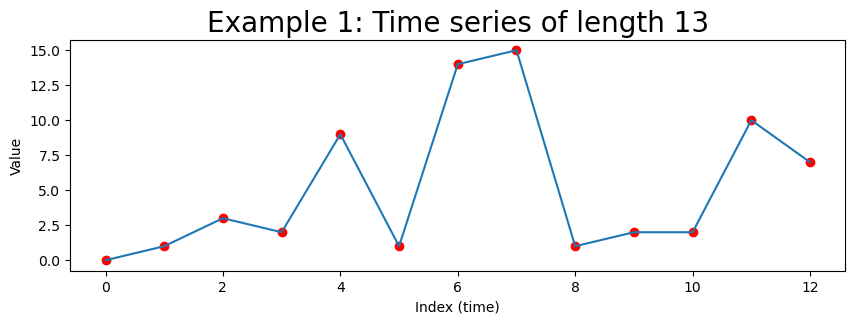

In [ ]:
#| hide
# Example following Stumpy's 13-length case
plt.close('all')
foo_data = np.array([0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7])
foo_title = title = "Example 1: Time series of length 13"
show_sequence([foo_data], hide_rows = True, hide_columns = False)
plot_with_dots(
    time_series             = foo_data,
    title                   = foo_title,
    sequence_flag           = False,
    fontsize                = 20,
    figsize                 = (10,3)
) 

## Downsampling

### Piecewise Aggregate Approximation

In [ ]:
#| export
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

In [ ]:
#| export
@dataclass
class Interpolator(BaseEstimator, TransformerMixin):
    method            : str  ='linear'
    n_segments        : int  = 1
    plot_original_data: bool = False
    plot_interpolated : bool = False
    mssg              : Mssg = Mssg(function = "Interpolator")
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.mssg.initial(func_name = "Interpolator | transform")
        if X.ndim == 1:
            X = X.reshape(1, -1)
        
        if self.plot_original_data:
            self.mssg.print(f"Interpolator | Plot original data")
            for dim in range (X.ndim-1):
                self.mssg.print(f"Interpolator | Plot original data dimension {dim}", verbose_level = self.mssg.verbose + 1)
                plot_with_dots(
                    X[dim], 
                    sequence_flag = False, 
                    title = f'Original data | dim {dim}'
                )
                
        n_samples, n_features = X.shape
        if n_features % self.n_segments != 0 or n_features == self.n_segments:
            raise ValueError(
                f"The number of segments {self.n_segments} must divide (and be different of) the number of features {n_features} | Reminder: {n_features // self.n_segments}"
            )

        segment_size = n_features // self.n_segments
        interpolated_result = np.full_like(X, np.nan)

        self.mssg.print(f"NFeatures: {n_features} | NSegments: {self.n_segments} | segment_size: {segment_size} | interpolated result ~ {interpolated_result.shape}")
        
        for i in np.arange(self.n_segments):
            start = i * segment_size 
            end = start + segment_size
            segment_mean = np.nanmean(X[:, start:end], axis=1)
            for j in np.arange(n_samples):
                nan_mask = np.isnan(X[j, start:end])
                interpolated_result[j, start:end][nan_mask] = segment_mean[j]
        res = np.where(np.isnan(X), interpolated_result, X)
        if self.plot_interpolated:
            for dim in range (X.ndim-1):
                plot_with_dots(
                    res[dim], 
                    sequence_flag = False, 
                    title = f'Interpolated data | dim {dim}'
                )
        self.mssg.final()
        return res

[0] [ --> Interpolator | transform ]
[0]  [ Interpolator | transform ] NFeatures: 8 | NSegments: 4 | segment_size: 2 | interpolated result ~ (1, 8)


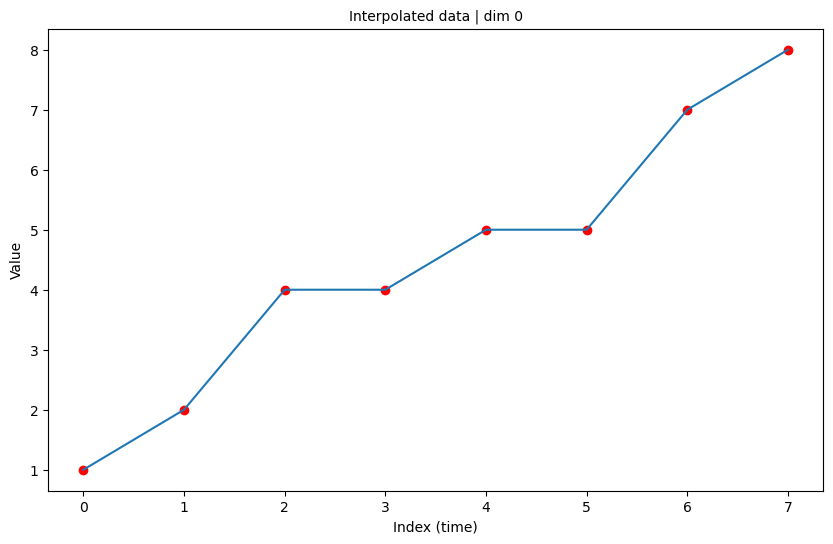

[0] [Interpolator | transform --> ]


In [ ]:
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])

foo_inter = Interpolator(
            method='polynomial', 
            n_segments         = 4,
            plot_interpolated  = True,
            plot_original_data = False,
            mssg               = Mssg(function = "foo_inter", verbose = 0)
        )

foo = foo_inter.fit_transform(foo_data)[0]

In [ ]:
#| export
@dataclass
class PAATransformer(BaseEstimator, TransformerMixin):
    n_segments       : int  = 1
    plot_aggregated  : bool = True
    mssg             : Mssg = Mssg(function = "PAATransformer")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_features = X.shape
        if n_features <= self.n_segments:
            raise ValueError(f"The number of segments ({self.n_segments}) must be lower than the number of points ({n_features})")

        segment_size = n_features // ( self.n_segments + 1)
        remainder = n_features % ( self.n_segments + 1)

        self.mssg.print(f"NFeatures: {n_features} | NSegments: {self.n_segments} | Segment size: {segment_size} | Reminder: {remainder}")

        # Crear un array para los resultados
        result = np.zeros((n_samples, self.n_segments + 1))

        self.mssg.print(f"Result ~ {result.shape}", verbose_level = self.mssg.level+1)

        # Procesar cada segmento
        for i in range(self.n_segments+1):
            start = i * segment_size + min(i, remainder)
            end = start + segment_size + (1 if i < remainder else 0)
            result[:, i] = np.mean(X[:, start:end], axis=1)

        if self.plot_aggregated:
            for dim in range (X.ndim-1):
                self.mssg.print(f"Plos res | Dim", {dim}, verbose_level = self.mssg.level+1)
                plot_with_dots(
                    result[dim], 
                    sequence_flag = False, 
                    title = f'Aggregated data | dim {dim}',
                    fontsize = 20,
                    save_plot = True
                )
        return result


[0] [ --> Interpolator | transform ]
[0]  [ Interpolator | transform ] NFeatures: 8 | NSegments: 4 | segment_size: 2 | interpolated result ~ (1, 8)


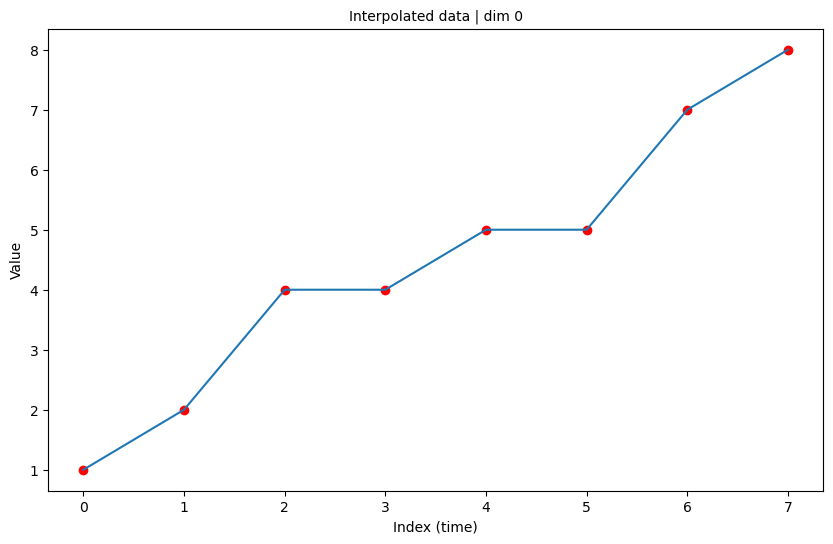

[0] [Interpolator | transform --> ]
[2]  [ interpolator | paa ] NFeatures: 8 | NSegments: 3 | Segment size: 2 | Reminder: 0
[2]  [ interpolator | paa ] Result ~ (1, 4)


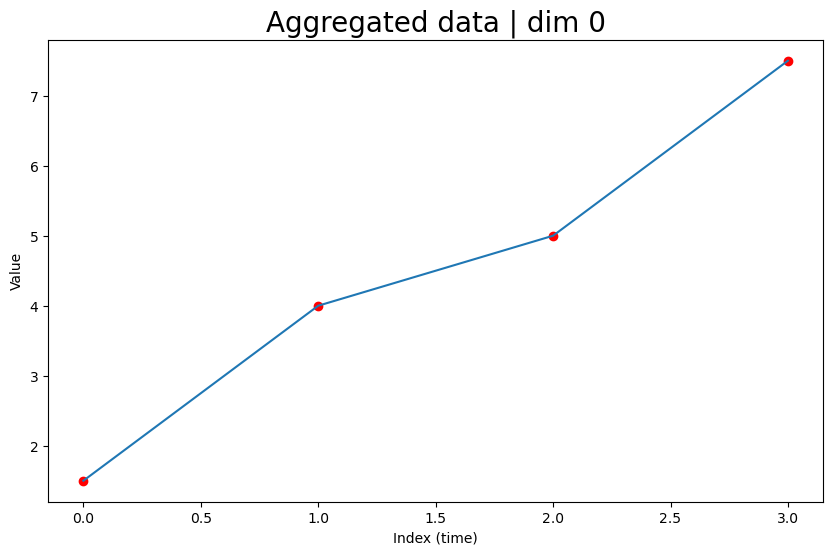

In [ ]:
#| hide
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])
foo_paa_pipeline = Pipeline([
    (
        # Step for interpolating NaNs in the original data
        'interpolator', 
        Interpolator(
            method='polynomial', 
            n_segments         = 4, 
            plot_interpolated  = True,
            plot_original_data = False,
            mssg               = Mssg(function = 'interpolator | polynomial')
        )
    ),
    (
        # Step for applying Peicewise Aggregated Approximation
        'paa', PAATransformer(
            n_segments      = 3, 
            plot_aggregated = True, 
            mssg         = Mssg(function = 'interpolator | paa', verbose = 2)
        )
    )
])


foo = foo_paa_pipeline.fit_transform(foo_data)[0]

In [ ]:
#| export
# Errors definitions
class DownsampleError(Exception):
    """Exception raised for errors in the downsample process."""
    def __init__(self, message="Invalid number of min/max points for the proposed time series. You must allow cropping and check the final length"):
        self.message = message
        super().__init__(self.message)
class DivisorsError(Exception):
    def __init__(self, message = "Invalid parameters"):
        self.message = message
        super().__init__(self.message)

In [ ]:
#| export
def divisors(
    N       : int, 
    min_val : int, 
    max_val : int, 
    mssg    : Mssg = Mssg()
) -> List [ int ] : 
    mssg.print(f"--> divisors")
    mssg_ = mssg.print_less()
    mssg_.print(f"Looking for the divisors of {N} between {min_val} and {max_val}")
    if (N < 0 or min_val < 0):
        mssg = f"N, min_val, max_val {N}, {min_val}, {max_val} must be a positive integer (>0)"
        raise DivisorsError(mssg)
    elif ( min_val > max_val):
        mssg = f"min_val > max_val ({min_val} > {max_val}). Please take a look"
        raise DivisorsError(mssg)
    arr = np.arange(min_val,max_val+1)
    arr = arr[ N % arr == 0]
    mssg_.print(f"Found {len(arr)} divisors of {N} between {min_val} and {max_val}")
    mssg.print("divisors -->")
    return arr

def downsample_propose_crop_(
    N            : int, 
    min_points   : int, 
    max_points   : int, 
    allow_crop   : bool = True,
    nearest_val  : bool = False,
    potential_val: int = 1,
    divisors_flag: bool = True,
    mssg         : Mssg = Mssg()
) -> int:
    mssg_ = mssg.print_less(func_name="divisors")
    mssg.initial(f"downsample_propose_crop_")
    mssg.print(f"Downsample Propose Crop | Prev N: {N}", verbose_level=mssg.level+1)
    
    all_divisors = divisors(
        N       = N, 
        min_val = min_points, 
        max_val = max_points,
        mssg    = mssg_
    )
    val = 0
    if len(all_divisors) == 0:
        if ( not nearest_val or potential_val < 1):
            raise ValueError("No valid divisors found for the given N within the min and max points range.")
    else:
        if ( nearest_val and potential_val > 0):
                val = min(all_divisors, key=lambda x: abs(x - potential_val))
        elif (divisors_flag):
            val = divisors(
                N       = N, 
                min_val = min_points, 
                max_val = max_points, 
                mssg    = mssg_
            )[-1]
    
    if (allow_crop):
        while (val < min_points and N > min_points): 
            N = N-1
            all_divisors = divisors(
                N       = N, 
                min_val = min_points, 
                max_val = max_points, 
                mssg    = mssg_
            )
            if len(all_divisors) > 0:
                if ( nearest_val and potential_val > 0):
                    val = min(all_divisors, key=lambda x: abs(x - potential_val))
    else: 
        raise DownsampleError()
        #return -1
    mssg.print(f"Post N: {N} | Largest Divisor: {val}", verbose_level=mssg.level+1)
    mssg.final()
    return (val, N)

In [ ]:
#| hide
foo         = Mssg()
foo.level   = 2
print_flush(str(downsample_propose_crop_(
    N               = 7397222, 
    min_points      = 10000, 
    max_points      = 20000, 
    allow_crop      = True, 
    nearest_val     = True, 
    potential_val   = 14500,
    mssg            = foo
)))

(15035, 7397220)


In [ ]:
#| export
def downsample(
    data            : List [ float ] = None,
    min_position    : int  = 0,
    max_position    : int  = -1, 
    min_points      : int  = 1,
    max_points      : int  = 10000,
    show_plots      : bool = False,
    allow_crop      : bool = True,
    mssg            : Mssg = Mssg()
) -> Tuple [ List [ float ], float ]:  
    if max_points >= data.shape[0]: return data, 1
    mssg_ = mssg.print_less()
    mssg.initial(func_name="downsample")
    mssg.print(f"Position | Before | Pos ({min_position}, {max_position})")
    min_position = min_position if min_position > 0 else 0
    max_position = max_position if ( max_position > -1 and max_position < data.shape[0]) else data.shape[0]
    mssg.print(f"Position | After | Pos ({min_position}, {max_position})")
    
    n_timestamps = max_position - min_position
    paa_factor   = np.maximum(1, n_timestamps // max_points)

    min_points   = max(1,min(min_points, data.shape[0]))
    max_points   = min(data.shape[0], min(max_points, max_position-min_position))

    mssg.print(f"downsample_propose_crop | Max points: {max_points}")
    mssg.print(f"downsample_propose_crop | Min points: {min_points}")
    
    min_points   = min(min_points, max_points)
    mssg.print(f"downsample_propose_crop | N timestamps {n_timestamps}")
    mssg.print(f"downsample_propose_crop | PAA factor: {paa_factor}")
    mssg.print(f"downsample_propose_crop | allow_crop: {allow_crop}")

    potential_segments = np.floor(n_timestamps / paa_factor).astype(int)
    
    N = max_position-min_position
    mssg_.function = "downsample_propose_crop_"
    mssg_.print(f" N: {N}")
    mssg_.print(f"potential_segments: {potential_segments}")

    n_segments, N = downsample_propose_crop_(
        N             = N, 
        min_points    = min_points,
        max_points    = max_points,
        allow_crop    = allow_crop,
        nearest_val   = allow_crop, # If allow_crop, try to get as near of potential_segment as possible
        potential_val = potential_segments, # The most desired one 
        mssg = mssg
    ) 

    if allow_crop: 
        mssg.print(f"downsample_propose_crop | Allow crop => change n_timestamp | Before {n_timestamps}", verbose_level=mssg.level+1)
        max_position = min_position + N
        mssg.print(f"downsample_propose_crop | Allow crop => change n_timestamp | After {n_timestamps}", verbose_level=mssg.level+1)
    
    data = data[min_position:max_position]
    n_timestamps = data.shape[0]

    mssg.print(f"--> | N segments: {n_segments} | Data ~ {data.shape}")
    mssg.print(f"--> | N = {N} | n_timestamps = {n_timestamps} | min_position {min_position} | max_position {max_position}")

    if n_timestamps < max_points: 
        mssg.print(f"[ Downsample ] n_timestamps {n_timestamps} < max_points {max_points}")
        return data, 1
    
    paa_pipeline = Pipeline([
        (
            # Step for interpolating NaNs in the original data
            'interpolator', 
            Interpolator(
                method             = 'polynomial', 
                n_segments         = n_segments, 
                plot_original_data = show_plots,
                plot_interpolated  = show_plots
            )
        ),
        (
            # Step for applying Peicewise Aggregated Approximation
            'paa', PAATransformer(
                n_segments      = n_segments, 
                plot_aggregated = show_plots
            )
        )
    ])

    ts_paa = paa_pipeline.fit_transform(data[min_position:max_position])[0]
    mssg.print(f"ts_paa~{len(ts_paa)}")
    mssg.final()
    return ts_paa, paa_factor

[5] [ --> downsample ]
[5]  [ downsample ] Position | Before | Pos (0, -1)
[5]  [ downsample ] Position | After | Pos (0, 8)
[5]  [ downsample ] downsample_propose_crop | Max points: 5
[5]  [ downsample ] downsample_propose_crop | Min points: 3
[5]  [ downsample ] downsample_propose_crop | N timestamps 8
[5]  [ downsample ] downsample_propose_crop | PAA factor: 1
[5]  [ downsample ] downsample_propose_crop | allow_crop: True
[5]  [ downsample_propose_crop_ ]  N: 8
[5]  [ downsample_propose_crop_ ] potential_segments: 8
[5]  [ divisors ] --> divisors
[5]  [ divisors ] Looking for the divisors of 8 between 3 and 5
[5]  [ divisors ] Found 1 divisors of 8 between 3 and 5
[5]  [ divisors ] divisors -->
[0] [ --> Interpolator | transform ]
[0]  [ Interpolator | transform ] Interpolator | Plot original data


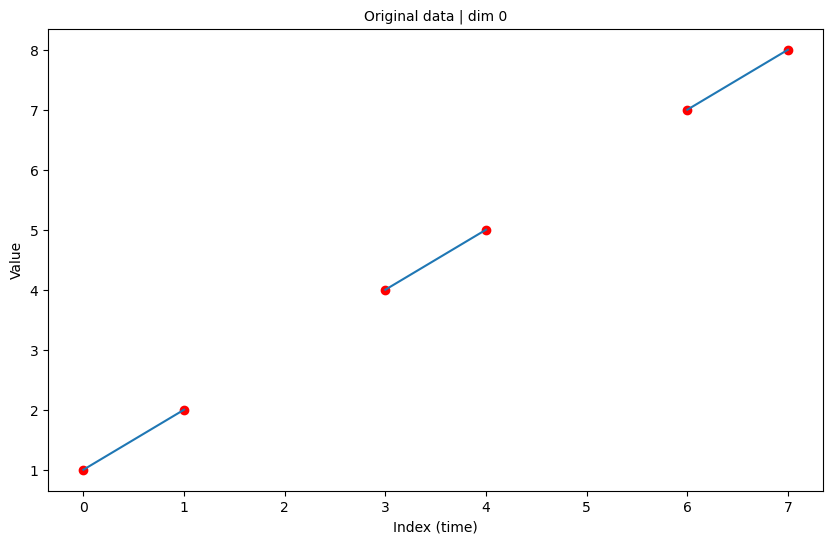

[0]  [ Interpolator | transform ] NFeatures: 8 | NSegments: 4 | segment_size: 2 | interpolated result ~ (1, 8)


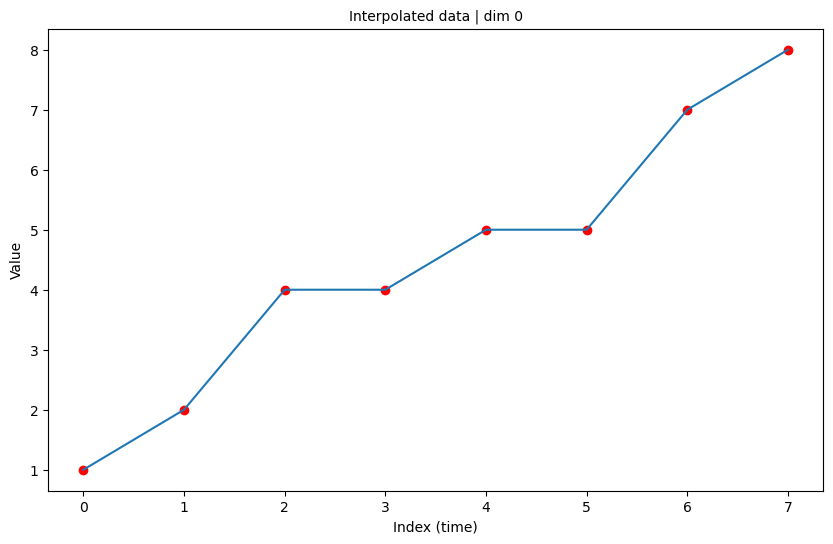

[0] [Interpolator | transform --> ]
[0]  [ PAATransformer ] NFeatures: 8 | NSegments: 4 | Segment size: 1 | Reminder: 3


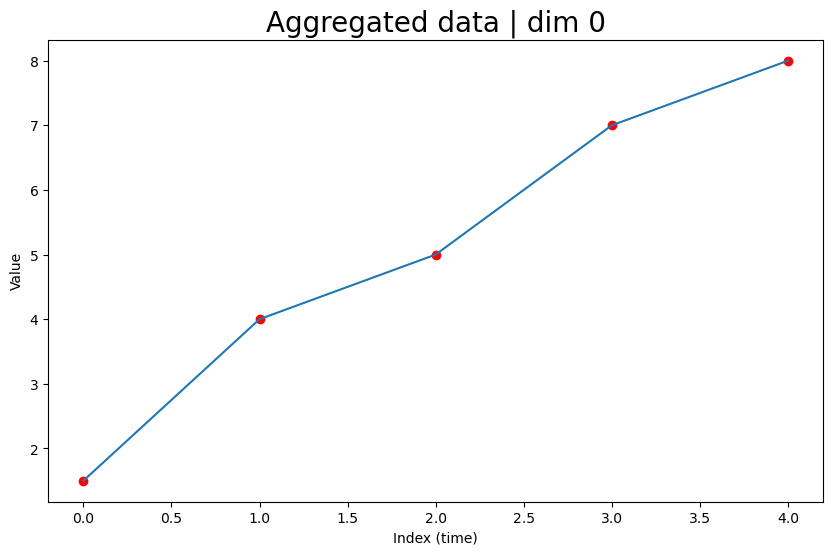

(array([1.5, 4. , 5. , 7. , 8. ]), 1)


In [ ]:
#| hide
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])
foo_data_2 = downsample(foo_data, min_points = 3, max_points = 5, mssg = Mssg(verbose = 5), show_plots = True)
print_flush(str(foo_data_2))

[5] [ --> downsample ]
[5]  [ downsample ] Position | Before | Pos (0, -1)
[5]  [ downsample ] Position | After | Pos (0, 7397222)
[5]  [ downsample ] downsample_propose_crop | Max points: 20000
[5]  [ downsample ] downsample_propose_crop | Min points: 10000
[5]  [ downsample ] downsample_propose_crop | N timestamps 7397222
[5]  [ downsample ] downsample_propose_crop | PAA factor: 369
[5]  [ downsample ] downsample_propose_crop | allow_crop: True
[5]  [ downsample_propose_crop_ ]  N: 7397222
[5]  [ downsample_propose_crop_ ] potential_segments: 20046
[5]  [ divisors ] --> divisors
[5]  [ divisors ] Looking for the divisors of 7397222 between 10000 and 20000
[5]  [ divisors ] Found 0 divisors of 7397222 between 10000 and 20000
[5]  [ divisors ] divisors -->
[5]  [ divisors ] --> divisors
[5]  [ divisors ] Looking for the divisors of 7397221 between 10000 and 20000
[5]  [ divisors ] Found 0 divisors of 7397221 between 10000 and 20000
[5]  [ divisors ] divisors -->
[5]  [ divisors ] --> d

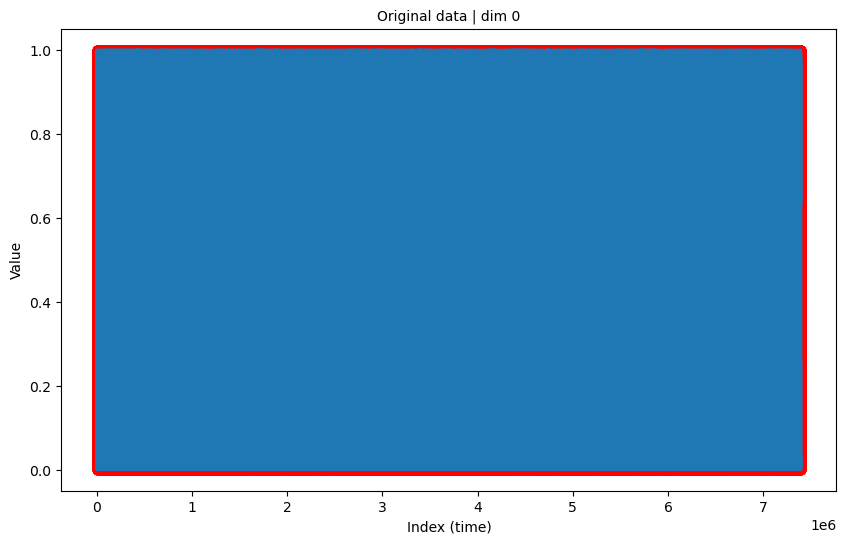

[0]  [ Interpolator | transform ] NFeatures: 7397220 | NSegments: 19885 | segment_size: 372 | interpolated result ~ (1, 7397220)


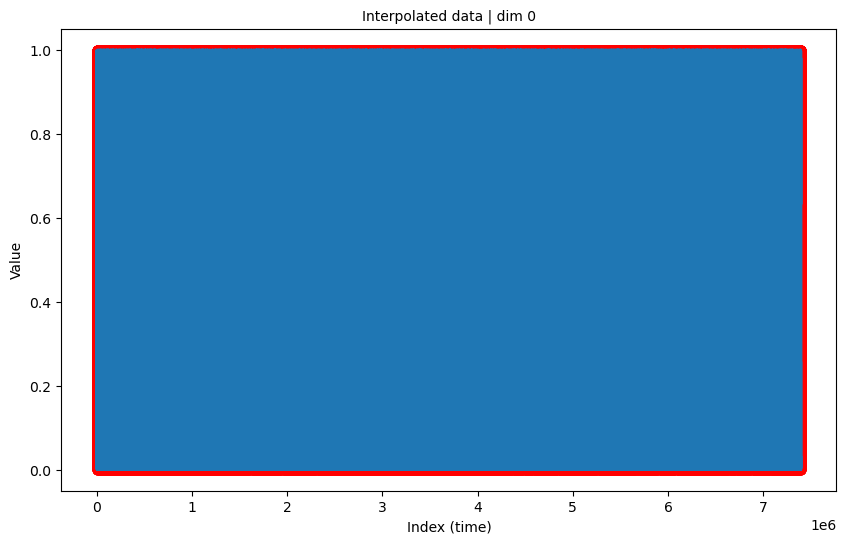

[0] [Interpolator | transform --> ]


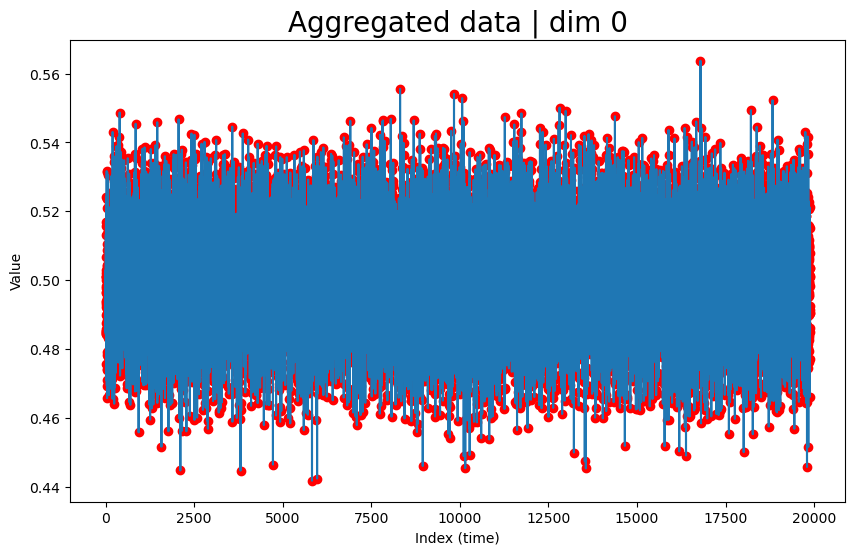

(array([0.49773968, 0.48529403, 0.49658634, ..., 0.47704832, 0.51513668,
        0.48504137]),
 369)

In [ ]:
#| hide
# Testing failed case
foo = np.random.rand(7397222)
downsample(foo, min_points = 10000, max_points = 20000, mssg = Mssg(verbose = 5), show_plots = True)

## Sizes

### Automatic sequence length selection

#### Following ClaSP example: best sequence length
In a similar way to ClaSP algorithm, our algorithms take the window size, w as hyper-parameter (see https://github.com/aeon-toolkit/aeon/blob/main/examples/segmentation/segmentation_with_clasp.ipynb). A simple method for choosing the window size is the dominant frequency of the Fourier Transform.

In [ ]:
#| export
from aeon.segmentation._clasp import ClaSPSegmenter, find_dominant_window_sizes
from aeon.datasets import load_electric_devices_segmentation
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles

In [ ]:
#| hide
? aeon.segmentation._clasp.find_dominant_window_sizes

Object ` aeon.segmentation._clasp.find_dominant_window_sizes` not found.


Dominant Period 10


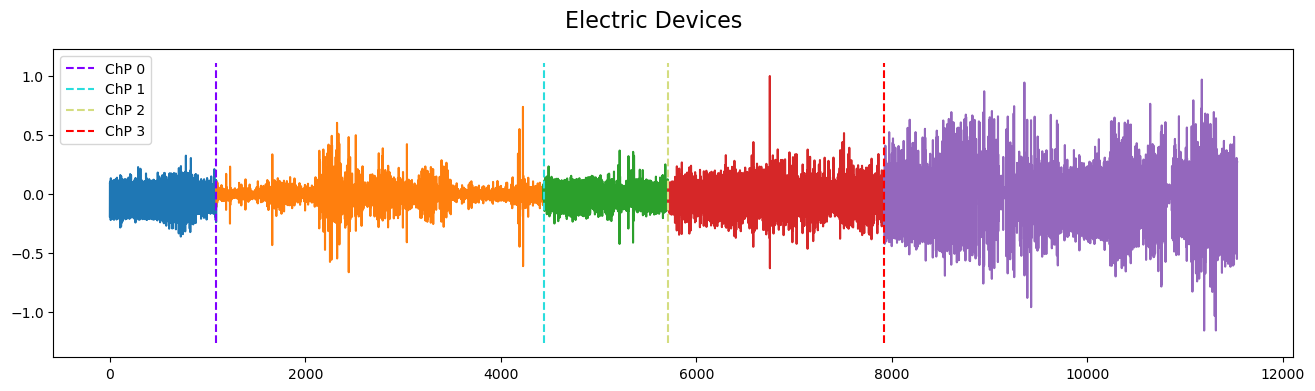

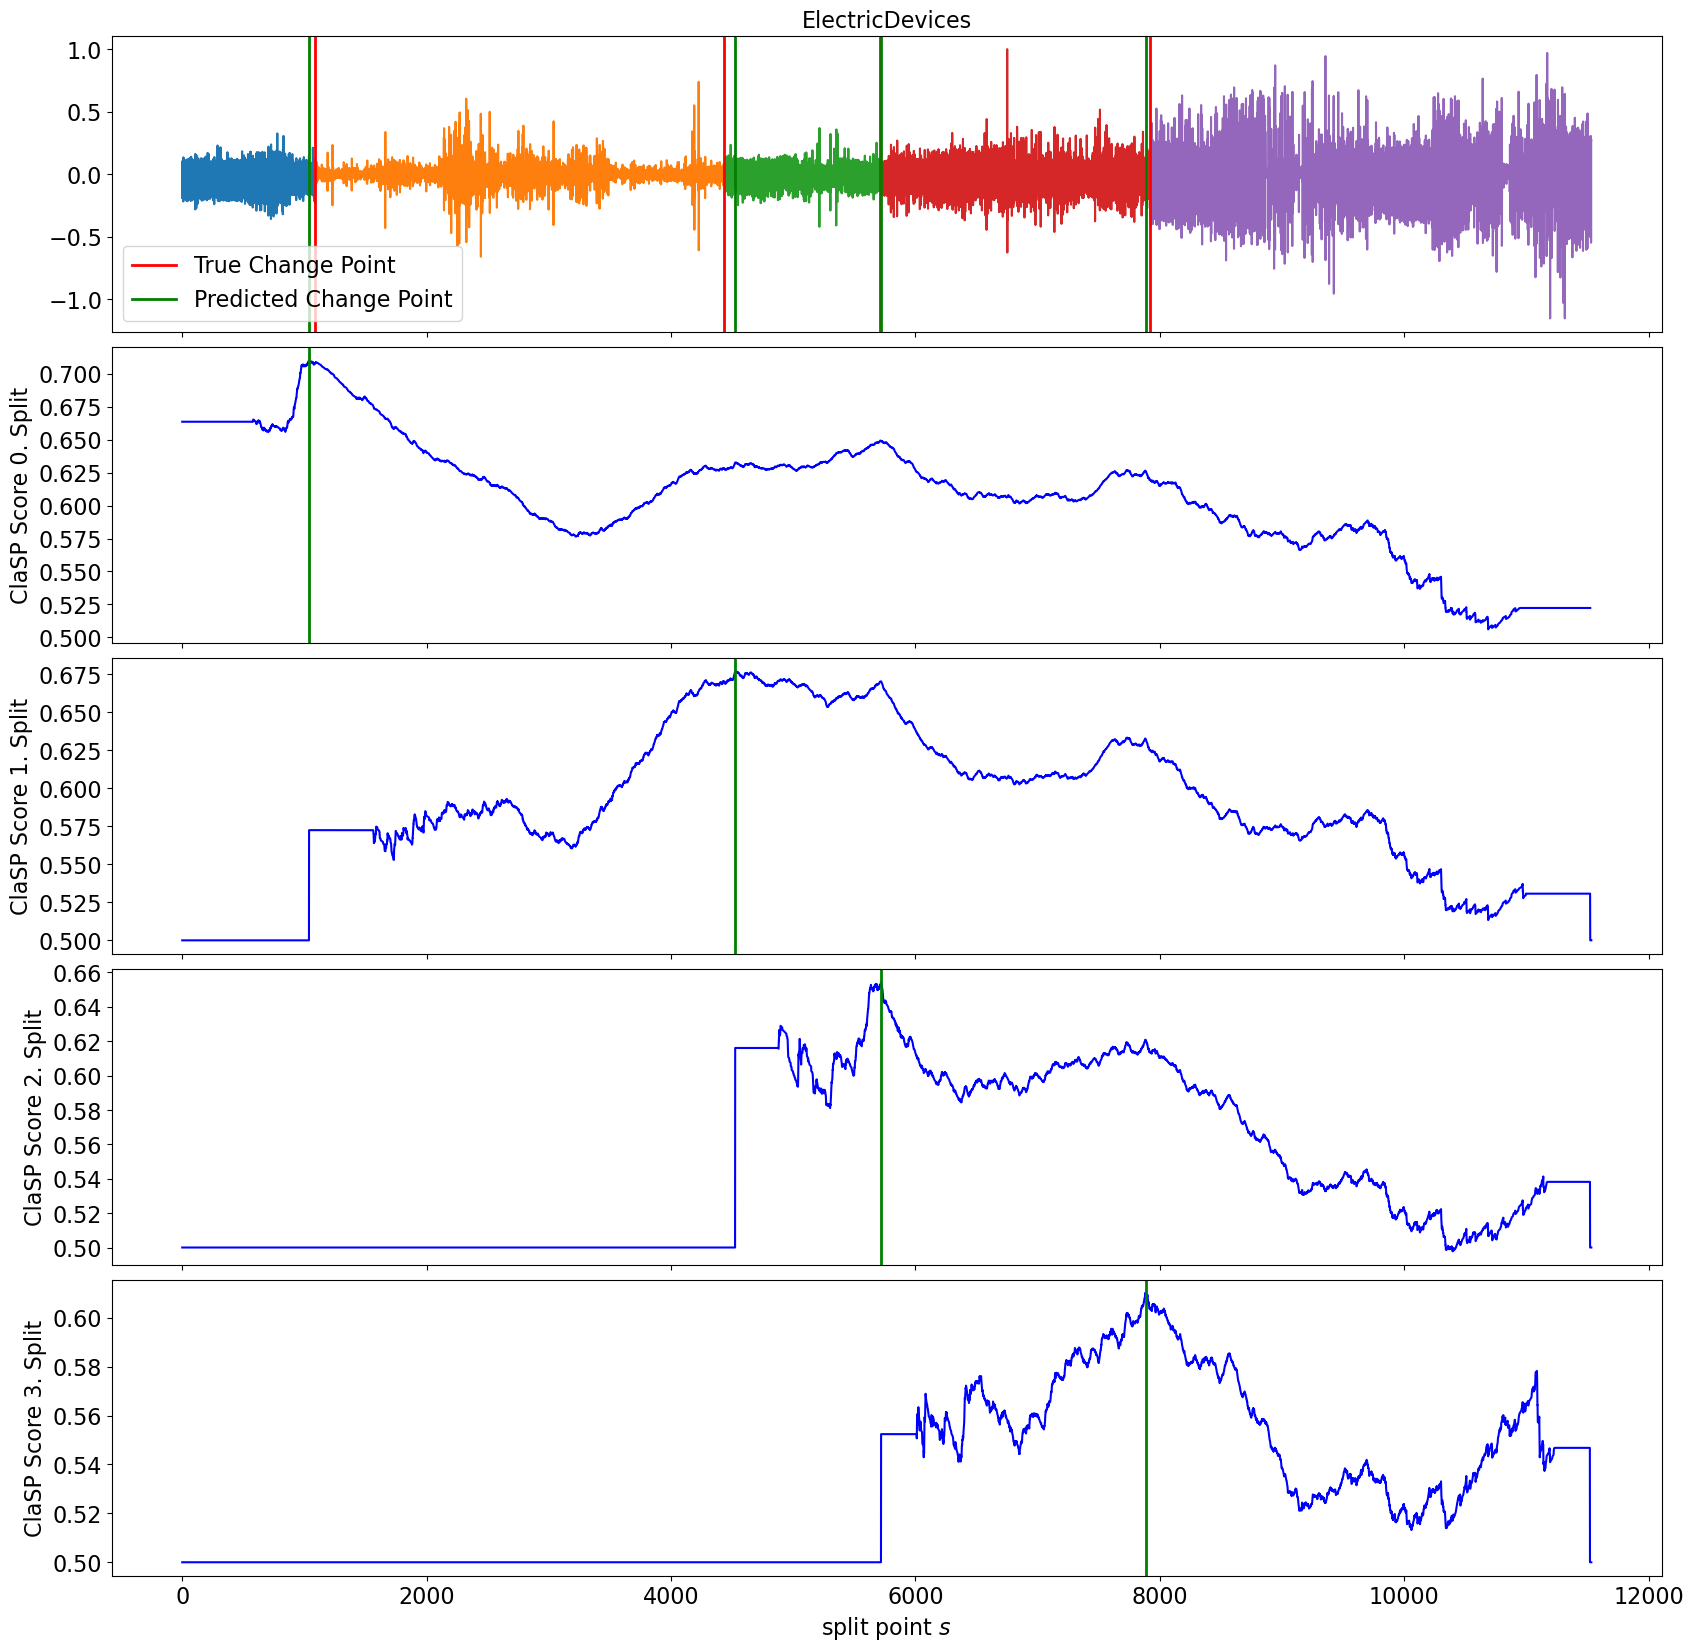

In [ ]:
#| hide
ts, period_size, true_cps = load_electric_devices_segmentation()
_ = plot_series_with_change_points(ts, true_cps, title="Electric Devices")
dominant_period_size = find_dominant_window_sizes(ts)
print_flush(f"Dominant Period {dominant_period_size}")
#| hide
clasp = ClaSPSegmenter(period_length=dominant_period_size, n_cps=5)
found_cps = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores

_ = plot_series_with_profiles(
    ts,
    profiles,
    true_cps=true_cps,
    found_cps=found_cps,
    title="ElectricDevices",
)

### Best nsizes sequence lengths

In [ ]:
#| export
def find_dominant_window_sizes_list_single_old(
        X            : List [ float ],
        nsizes       : int  = 1,
        offset       : float= 0.05, 
        mssg         : Mssg = Mssg()
    ) -> List [ int ]:
    mssg.initial_(f"Find_dominant_window_sizes_list")
    mssg.print(  f"X ~ {X.shape}", verbose = mssg.verbose + 1)
    mssg.print(  f"Looking for - at most - the best {nsizes} window sizes", verbose = mssg.verbose - 1)
    mssg.print(  f"Offset {offset} max size: {offset*len(X)}", verbose = mssg.verbose - 1)
    mssg.print(  f"Find_dominant_window_sizes_list | --> Freqs")
        
    X = np.array(X)
    fourier = np.absolute(np.fft.fft(X))   
    freqs = np.fft.fftfreq(X.shape[0], 1)
     
    mssg.print(  f"Freqs {freqs} -->", verbose_level = mssg.level + 1)
    mssg.print(  f"coefs {fourier} -->")
    mssg.print(  f"Freqs -->")

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)
    
    mssg.print( f"Coefs and window_sizes -->")
    mssg.print( f"--> Find and return valid window_sizes")

    idx = np.argsort(coefs)[::-1]
    
    mssg.print( f"Find and return valid window_sizes | ... 0 ... {idx}", verbose = mssg.verbose + 1)
        
    sorted_window_sizes = window_sizes[idx]
    
    mssg.print( "Find and return valid window_sizes | ... 1 ...", verbose = mssg.verbose + 1)

    # Find and return all valid window sizes
    valid_window_sizes = [
        int(window_size / 2) for window_size in sorted_window_sizes
        #if 20 <= window_size < int(X.shape[0] * offset)
        if 20 <= window_size < int(len(X) * offset)
    ]
    
    mssg.print( "Find and return valid window_sizes | ... 2 ...", verbose = mssg.verbose+1)

    # If no valid window sizes are found, return the first from sorted list
    if not valid_window_sizes:
        mssg.print( f"Find and return valid window_sizes | ... 2a ... {nsizes}", verbose = mssg.verbose + 1)
        sizes = [sorted_window_sizes[0] // 2][:nsizes]
    else:
        mssg.print( f"Find and return valid window_sizes | ... 2b ... {nsizes}", verbose = mssg.verbose + 1)
        sizes = valid_window_sizes[:nsizes]
        
    mssg.print(f"Find and return valid window_sizes -->")
    mssg.print(f"Sizes: {sizes}", verbose = mssg.verbose+2)
    mssg.final()
    
    return sizes

In [ ]:
#| export 
def select_separated_sizes(
    xs : List [ int ],
    min_distance : int = 1,
    nsizes          : int = 1
) -> List [ int ]:
    ys = []
    for window_size in xs:
        if not ys or abs(window_size - ys[-1]) >= min_distance:
            ys.append(window_size)
        if len(ys) == nsizes:
            break
    return ys

In [ ]:
#| hide 
xs = [0, 1, 3, 5, 4, 14, 23, 10, 6, 9, 13, 18, 16, 11, 15, 19, 8, 2, 22, 26, 7, 28, 12, 24, 17, 38, 34, 25, 30, 20, 54, 49, 27, 31, 55, 39, 128, 52, 46, 36, 53, 21, 68, 50, 89, 56, 41, 117, 66, 67, 40, 60, 112, 96, 114, 87, 65, 88, 81, 64, 75, 57, 235, 135, 43, 58, 59, 86, 63, 70, 177, 62, 125, 93, 32, 162, 172, 143, 84, 110, 95, 100, 77, 35, 150, 161, 48, 51, 82, 164, 192, 29, 101, 42, 91, 73, 78, 215, 156, 230, 108, 45, 214, 248, 165, 145, 115, 90, 136, 80, 104, 160, 208, 94, 216, 140, 263, 85, 159, 126, 242, 148, 151, 218, 79, 168, 131, 270, 223, 265, 179, 271, 232, 186, 207, 111, 71, 191, 266, 204, 132, 250, 174, 129, 37, 210, 205, 166, 121, 189, 154, 201, 139, 190, 74, 175, 141, 118, 196, 197, 228, 123, 113, 149, 147, 217, 102, 182, 134, 173, 33, 240, 259, 105, 269, 171, 130, 243, 76, 195, 72, 245, 167, 198, 47, 97, 120, 137, 241, 153, 98, 219, 116, 187, 267, 238, 220, 124, 251, 260, 92, 106, 188, 169, 253, 133, 170, 44, 142, 194, 61, 213, 99, 193, 212, 200, 203, 234, 256, 262, 236, 69, 246, 225, 264, 222, 273, 122, 158, 258, 202, 119, 247, 244, 229, 231, 183, 233, 261, 181, 227, 224, 127, 138, 144, 226, 254, 103, 176, 237, 157, 155, 146, 83, 199, 255, 107, 252, 221, 180, 209, 184, 268, 257, 178, 206, 211, 185, 239, 109, 163, 249, 272, 152]
select_separated_sizes(xs, 5, 3)

[0, 5, 14]

In [ ]:
#| export
def find_dominant_window_sizes_list_single(
        X            : List[float],
        nsizes       : int               = 1,
        offset       : float             = 0.05, 
        min_distance : int               = 1,    # Asegurar distancia mínima entre tamaños
        # Print options
        mssg         : Mssg              = Mssg()
    ) -> List[int]:
    mssg.initial("find_dominant_window_sizes_list_single")
    mssg.print( f"X ~ {X.shape}", verbose_level = mssg.level + 1)
    mssg.print( f"Looking for - at most - the best {nsizes} window sizes")
    mssg.print( f"Offset {offset} max size: {offset*len(X)}")
    mssg.print( f"--> Freqs")
        
    X = np.array(X)
    
    fourier = np.absolute(np.fft.fft(X))   
    freqs = np.fft.fftfreq(X.shape[0], 1)
    
    mssg.level += 2
    mssg.print( f"Find_dominant_window_sizes_list | Freqs {freqs} -->")
    mssg.print( f"Find_dominant_window_sizes_list | coefs {fourier} -->")
    mssg.level -= 2
    mssg.print( f"Find_dominant_window_sizes_list | Freqs -->")

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)
    
    mssg.print( "Find_dominant_window_sizes_list | Coefs and window_sizes -->")
    mssg.print( "Find_dominant_window_sizes_list | --> Find and return valid window_sizes")

    idx = np.argsort(coefs)[::-1]
    
    mssg.level += 1
    mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 0 ... {idx}")
        
    sorted_window_sizes = window_sizes[idx]
    
    mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 1 ... {idx}")

    # Find and return all valid window sizes
    valid_window_sizes = [
        int(window_size) for window_size in sorted_window_sizes
        if window_size < int(len(X) * offset)
    ]
    
    mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2 ... {idx}")

    # Ensure sizes separated at least at "min_distance" 
    sizes = select_separated_sizes(valid_window_sizes, min_distance, nsizes)

    # If no valid window sizes are found, return the first from sorted list
    if not sizes:
        mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2a ... {nsizes}")
        sizes = sorted_window_sizes[0][:nsizes]
    else:
        mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2b ... {nsizes}")
    mssg.level -= 1
    mssg.print(f"Find_dominant_window_sizes_list | Find and return valid window_sizes -->")
    mssg.print(f"Find_dominant_window_sizes_list | Sizes: {sizes}", verbose_level=mssg.level + 1)
    mssg.print(f"Find dominant_window_sizes_list --->")
    return sizes

In [ ]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


In [ ]:
#| export
def group_similar_sizes(vars_sizes, nsizes, tolerance=2):
    """
    Selects the best window sizes across multiple variables,
    ensuring no repetitions and that the sizes are sufficiently close.
    """
    indices = [0] * len(vars_sizes)  # Indices for each variable
    selected_sizes = []  # Selected window sizes

    while len(selected_sizes) < nsizes:
        # Get the smallest available size across all variables
        current_sizes = [vars_sizes[i][indices[i]] for i in range(len(vars_sizes)) if indices[i] < len(vars_sizes[i])]
        min_size = min(current_sizes)

        # Select sizes close to the minimum and avoid duplicates
        for i in range(len(vars_sizes)):
            if indices[i] < len(vars_sizes[i]) and abs(vars_sizes[i][indices[i]] - min_size) <= tolerance:
                if vars_sizes[i][indices[i]] not in selected_sizes:  # Avoid duplicates
                    selected_sizes.append(vars_sizes[i][indices[i]])
                indices[i] += 1  # Move to the next size for that variable

                if len(selected_sizes) >= nsizes:
                    break

        # End if no more sizes are left in any variable
        if all(idx >= len(vars_sizes[i]) for i, idx in enumerate(indices)):
            break

    # Remove duplicates from the selected sizes and return the first nsizes
    selected_sizes = list(dict.fromkeys(selected_sizes))  # Remove duplicates
    return selected_sizes[:nsizes]



In [ ]:
#| export
def find_dominant_window_sizes_list(
        X,
        nsizes          : int   = 1,
        offset          : float = 0.05, 
        min_distance    : int   = 1,
        mssg            : Mssg  = Mssg()
    ) -> List [ int ]:
    mssg.initial_(f"Find_dominant_window_sizes_list")
    if len(X.shape) == 1: 
        sizes = find_dominant_window_sizes_list_single(X,nsizes,offset, min_distance, mssg)
    else: 
        if ( isinstance(X, pd.DataFrame ) ): X = X.values
        mssg.print( f"X ~ {X.shape}")
        mssg.level += 1
        vars_sizes = []
        for var in range( X.shape[1] ):
            mssg.print( f"Get sizes for var {var}")
            var_sizes = find_dominant_window_sizes_list_single(X[:, var], nsizes, offset, min_distance, mssg = mssg)
            vars_sizes.append(var_sizes)
            mssg.print(f"Get sizes for var {var} | {var_sizes}")
        mssg.level -= 1
        mssg.print( f"Grouping sizes")
        sizes = group_similar_sizes(vars_sizes, nsizes, tolerance = 2)
        mssg.print(f"Final selected window sizes: {sizes}", verbose_level = mssg.level + 1)
    mssg.final()
    return sizes

In [ ]:
#| hide
foo = steam_df['steam flow']
dominant_period_size = find_dominant_window_sizes(
    foo, 
    offset = 0.05
)
print_flush(f"Dominant Period {dominant_period_size}")
dominant_period_sizes = find_dominant_window_sizes_list(
    foo, 
    nsizes = 5, 
    offset = 0.05,
    mssg   = Mssg (verbose = 1)
)
print_flush(f"Dominant Period Sizes {dominant_period_sizes}")
dominant_period_sizes = find_dominant_window_sizes_list(
    foo, 
    nsizes = 5, 
    offset = 0.6,
    mssg   = Mssg ( verbose = 1)
)
print_flush(f"Dominant Period Sizes {dominant_period_sizes}")

Dominant Period 191
Dominant Period Sizes [383, 369, 282, 436, 320]
Dominant Period Sizes [383, 800, 369, 1600, 282]


## Classes utilities

In [ ]:
#| export
import warnings
def _check_value(
    value       : Any,
    default     : Any,
    name        : str   = "",
    valid_types : Union [ type, List[type] ] = [ int ],
    allow_none  : bool  = False,
    positive    : bool  = False,
    percent     : bool  = False,
    mssg        : Mssg  = Mssg()
):
    level = mssg.level
    mssg.initial(f"{funcname(2)} | {funcname(1)} | {funcname()} | {name}", verbose_level = mssg.level+1)
    res = default
    valid = True
    if value is None and not allow_none:
        valid = False
    if valid and value is not None:
        if percent:
            positive = True
            valid_types = [ int, float]
        valid_types = valid_types if isinstance(valid_types, list) else [valid_types]
        mssg.print(f"Checking if {value}'s type is one of {valid_types}", verbose_level = mssg.level + 5)
        if not isinstance(value, tuple(valid_types)):
            valid_type_names = ", ".join(t.__name__ for t in valid_types)
            warnings.warn(
                f"Invalid type for '{name}' ({type(value).__name__}). Expected one of: {valid_type_names}. Using default: {default}"
            )
            valid = False
        if valid and isinstance(value, (float, int)) and not math.isfinite(value):
            mssg.print(f"Value {value} is not finite", verbose_level = mssg.level + 5)
            warnings.warn(f"'{name}' is not finite ({value}). Using default: {default}")
            valid = False
    
        if valid and positive and isinstance(value, (float, int)) and value <= 0:
            mssg.print(f"Value {value} is not positive")
            warnings.warn(f"'{name}' must be positive ({value}). Using default: {default}")
            valid = False
        if valid and percent and value > 1:
            warnings.warn(f"'{name}' must be lower or equal than 1 ({value}). Using default: {default}")
            valid = False
    if valid: res = value
    mssg.print(f"valid? {valid}", verbose_level = mssg.level + 1)
    mssg.final(verbose_level = mssg.level+1)
    mssg.level = level
    return res, valid

In [ ]:
#| export
def _validate_nested_list(value, default, name, valid_types, levels, 
    allow_none  : bool  = False,
    positive    : bool  = False,
    percent     : bool  = False,
    mssg        : Mssg  = Mssg()
):
    """
    Validates that a value is a nested list with exactly 'levels' levels
    and that the innermost level contains elements of the 'valid_types'.
    
    Parameters:
    - value: Any - The value to validate.
    - valid_types: type - The expected type for the innermost elements.
    - levels: int - The exact number of nested list levels expected.
    
    Returns:
    - bool: True if the value is valid, False otherwise.
    """
    mssg.initial(f"{funcname()} | level {levels}")
    # Base case: if levels == 0, the value must be of the expected type
    valid_types = valid_types if isinstance(valid_types, list) else [valid_types]
    valid_types = tuple(valid_types)
    if levels == 0:
        return _check_value(value, default, name, valid_types, allow_none, positive, percent)

    # Check if the value is a list
    if not isinstance(value, list):
        return default
    # Initialize the results list and overall validity
    validated_list = []
    overall_valid = True
    # Recursively validate each element, reducing levels
    for idx, item in enumerate(value):
        mssg.print(f"Validating item {idx} at level {levels}")
        validated_item, item_valid = _validate_nested_list(
            item,
            default, name, valid_types, levels - 1,
            allow_none, positive, percent, mssg
        )
        validated_list.append(validated_item)
        overall_valid = overall_valid and item_valid
    mssg.print(averall_valid)
    valid = all(averall_valid)
    mssg.print(f"valid? {valid}")
    mssg.final(f"{funcname()} | level {levels}")
    return res, valid


In [ ]:
#| hide 
print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

Execution ended
